In [1]:
import numpy as np
import json
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2025-06-05 17:08:23.694650: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configurations

In [2]:
ai_ready_dir = "Dataset/ai_ready_data" # 

# Check if the directory and files exist
if not os.path.isdir(ai_ready_dir):
    print(f"Error: Directory '{ai_ready_dir}' not found")

# File paths
X_train_file = os.path.join(ai_ready_dir, "X_train.npy")
y_train_file = os.path.join(ai_ready_dir, "y_train.npy")
X_val_file = os.path.join(ai_ready_dir, "X_val.npy")
y_val_file = os.path.join(ai_ready_dir, "y_val.npy")
X_test_file = os.path.join(ai_ready_dir, "X_test.npy")
y_test_file = os.path.join(ai_ready_dir, "y_test.npy")
grid_map_file = os.path.join(ai_ready_dir, "grid_id_to_index.json")
feature_cols_file = os.path.join(ai_ready_dir, "feature_columns.json") # Though not directly used in model architecture

data_loaded_successfully = True

# Load the preprocessed Data

In [17]:
try:
    # Load datasets
    print("Loading data...")
    X_train_scaled = np.load(X_train_file, allow_pickle=True)
    y_train = np.load(y_train_file, allow_pickle=True)
    X_val_scaled = np.load(X_val_file, allow_pickle=True)
    y_val = np.load(y_val_file, allow_pickle=True)
    
    # Load test set
    X_test_scaled = None
    y_test = None
    if os.path.exists(X_test_file) and os.path.exists(y_test_file):
        X_test_scaled = np.load(X_test_file, allow_pickle=True)
        y_test = np.load(y_test_file, allow_pickle=True)
        print("Test data loaded.")
    else:
        print("Test data not found, proceeding without it for evaluation.")

    # Load grid_id to index mapping to determine num_classes
    with open(grid_map_file, "r") as f:
        grid_id_to_index = json.load(f)
    num_classes = len(grid_id_to_index)

    # Load feature columns 
    with open(feature_cols_file, "r") as f:
        feature_columns = json.load(f)
    
    print("Data loaded successfully.")

except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Please ensure all .npy and .json files are in the 'ai_ready_data' directory.")
    data_loaded_successfully = False
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    data_loaded_successfully = False

if data_loaded_successfully:
    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val_scaled shape: {X_val_scaled.shape}")
    print(f"y_val shape: {y_val.shape}")
    if X_test_scaled is not None:
        print(f"X_test_scaled shape: {X_test_scaled.shape}")
        print(f"y_test shape: {y_test.shape}")
    print(f"Number of features: {X_train_scaled.shape[2]}")
    print(f"Sequence length: {X_train_scaled.shape[1]}")
    print(f"Number of unique grid_ids (classes): {num_classes}")
    # Ensure input data is float32
    if X_train_scaled.dtype == 'object':
        print("Attempting to convert X_train_scaled to float32...")
        try:
            X_train_scaled = X_train_scaled.astype(np.float32)
            print(f"X_train_scaled dtype after conversion: {X_train_scaled.dtype}")
        except ValueError as ve:
            print(f"ValueError during X_train_scaled conversion: {ve}")
            print("This often means non-numeric strings are present. Please check data preparation.")
            data_loaded_successfully = False # Halt further processing
    if X_val_scaled.dtype == 'object':
        print("Attempting to convert X_val_scaled to float32...")
        try:
            X_val_scaled = X_val_scaled.astype(np.float32)
            print(f"X_val_scaled dtype after conversion: {X_val_scaled.dtype}")
        except ValueError as ve:
            print(f"ValueError during X_val_scaled conversion: {ve}")
            data_loaded_successfully = False # Halt further processing
            
    if X_test_scaled is not None and X_test_scaled.dtype == 'object':
        print("Attempting to convert X_test_scaled to float32...")
        try:
            X_test_scaled = X_test_scaled.astype(np.float32)
            print(f"X_test_scaled dtype after conversion: {X_test_scaled.dtype}")
        except ValueError as ve:
            print(f"ValueError during X_test_scaled conversion: {ve}")
            # data_loaded_successfully = False # Potentially halt if test is crucial now

Loading data...
Test data loaded.
Data loaded successfully.
X_train_scaled shape: (4792, 10, 252)
y_train shape: (4792,)
X_val_scaled shape: (1026, 10, 252)
y_val shape: (1026,)
X_test_scaled shape: (1028, 10, 252)
y_test shape: (1028,)
Number of features: 252
Sequence length: 10
Number of unique grid_ids (classes): 212350
Attempting to convert X_train_scaled to float32...
X_train_scaled dtype after conversion: float32
Attempting to convert X_val_scaled to float32...
X_val_scaled dtype after conversion: float32
Attempting to convert X_test_scaled to float32...
X_test_scaled dtype after conversion: float32


# Data Preprocessing for LSTM

In [18]:
# Target variable (y) needs to be one-hot encoded for categorical_crossentropy
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
if y_test is not None:
    y_test_encoded = to_categorical(y_test, num_classes=num_classes)

print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_val_encoded shape: {y_val_encoded.shape}")
if y_test is not None:
    print(f"y_test_encoded shape: {y_test_encoded.shape}")

# Define sequence_length and num_features from the loaded data
sequence_length = X_train_scaled.shape[1]
num_features = X_train_scaled.shape[2]

y_train_encoded shape: (4792, 212350)
y_val_encoded shape: (1026, 212350)
y_test_encoded shape: (1028, 212350)


# Define Model Archtecture

In [19]:
model = Sequential()

# Input layer
model.add(Input(shape=(sequence_length, num_features)))

# LSTM layer 1
model.add(LSTM(128, return_sequences=False)) # Changed to False as it's the only LSTM layer for now
model.add(Dropout(0.3))

# Dense hidden layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

2025-06-05 17:25:29.517981: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 108723200 exceeds 10% of free system memory.
2025-06-05 17:25:29.541729: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 108723200 exceeds 10% of free system memory.


# Model compilation

In [20]:
# Using Adam optimizer and categorical_crossentropy for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │       195,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 212350)         │    27,393,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,604,734 (105.30 MB)

 Trainable params: 27,604,734 (105.30 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 550ms/step - accuracy: 0.6445 - loss: 7.5704 - val_accuracy: 0.3216 - val_loss: 19.8444
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 441ms/step - accuracy: 0.7146 - loss: 1.0087 - val_accuracy: 0.3216 - val_loss: 18.5631
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 441ms/step - accuracy: 0.7135 - loss: 1.0078 - val_accuracy: 0.3216 - val_loss: 17.3784
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.7226 - loss: 0.9631 - val_accuracy: 0.3216 - val_loss: 16.0895
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 437ms/step - accuracy: 0.7232 - loss: 0.9310 - val_accuracy: 0.3216 - val_loss: 14.1198
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 437ms/step - accuracy: 0.7459 - loss: 0.7500 - val_accuracy: 0.3197 - val_loss: 13.1485
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.8607 - loss: 0.4644 - val_accuracy: 0.3177 - val_loss: 12.9274
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 437ms/step - accuracy: 0.8680 - loss: 0.3897 - v

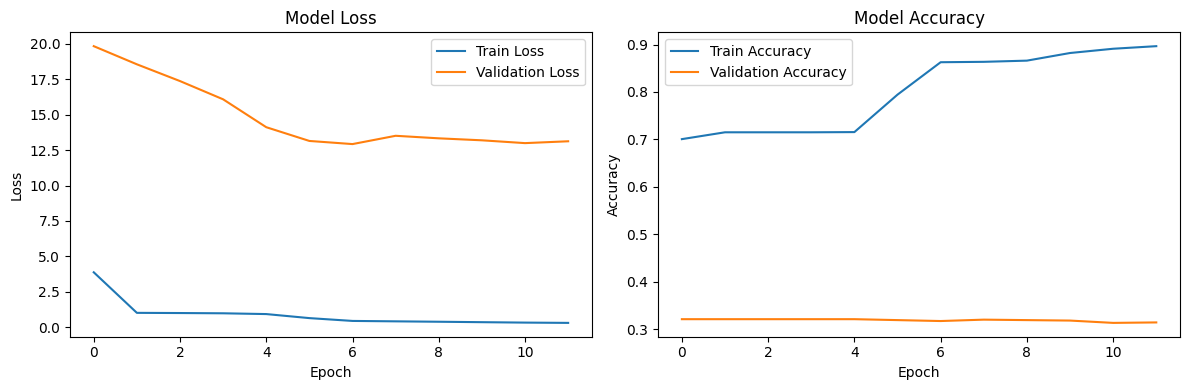

In [21]:
# Using a modest number of epochs and batch_size as a starting point.
# Early stopping can be useful to prevent overfitting and stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_encoded,
    epochs=20, # Adjust as needed; may require more for convergence
    batch_size=64, # Adjust based on memory and dataset size
    validation_data=(X_val_scaled, y_val_encoded),
    callbacks=[early_stopping]
)

# Plot training history (loss and accuracy)
print("\nPlotting training history...")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
# Saving the plot to a file
plot_filename = "training_history.png"
plt.savefig(plot_filename)
print(f"Training history plot saved to {plot_filename}")
# plt.show() # Use this if running in an environment that displays plots directly

# Evaluation

In [6]:
def evaluate_model(model, X_test, y_test, num_classes):
    """Evaluates the trained model on the test set."""
    if X_test.size == 0 or y_test.size == 0:
        print("No test data to evaluate.")
        return

    print("Evaluating model on test data...")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification report and confusion matrix can be very large for many classes
    if num_classes <= 50:  # Arbitrary threshold to avoid excessive output
        try:
            y_pred_probs = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred_probs, axis=1)
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_classes, zero_division=0))
            # print("\nConfusion Matrix (sample):") # Full matrix too large
            # print(confusion_matrix(y_test, y_pred_classes)) # Might be too large to print meaningfully
        except Exception as e:
            print(f"Could not generate classification report/confusion matrix: {e}")
    else:
        print(
            f"Skipping classification report due to large number of classes ({num_classes})."
        )
        print(
            "Consider implementing Top-N accuracy or other relevant metrics for high-cardinality classification."
        )

# Plot the training history

In [7]:
def plot_history(history):
    """Plots training and validation loss and accuracy."""
    if history is None:
        print("No training history to plot.")
        return

    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper right")

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    if "val_accuracy" in history.history:
        plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.savefig("training_history.png")
    print("Training history plot saved as training_history.png")
    # plt.show() # Uncomment if running in an environment that supports interactive plots

# Save Model in ONNX format

In [8]:
def save_model_onnx(keras_model_path, onnx_model_path, sequence_length, num_features):
    """Converts and saves the Keras model to ONNX format."""
    try:
        import tf2onnx
        import tensorflow as tf  # Ensure tf is available for tf.keras.models.load_model

        print(f"Loading Keras model from {keras_model_path} for ONNX conversion...")
        model = tf.keras.models.load_model(
            keras_model_path
        )  # Load the best saved Keras model

        # Define the input signature for the ONNX model
        # Batch size is dynamic (None), sequence length and num_features are fixed.
        spec = (
            tf.TensorSpec(
                (None, sequence_length, num_features), tf.float32, name="input"
            ),
        )

        print(f"Converting Keras model to ONNX format (saving to {onnx_model_path})...")
        model_proto, _ = tf2onnx.convert.from_keras(
            model, input_signature=spec, opset=13
        )  # opset can be adjusted

        with open(onnx_model_path, "wb") as f:
            f.write(model_proto.SerializeToString())
        print(f"Model successfully converted and saved to {onnx_model_path}")

    except ImportError:
        print("tf2onnx library not found. Skipping ONNX conversion.")
        print("To install: pip install tf2onnx")
    except Exception as e:
        print(f"An error occurred during ONNX conversion: {e}")

# The main execution segment

In [9]:
if __name__ == "__main__":
    # Load data
    (
        X_train_scaled,
        y_train,
        X_val_scaled,
        y_val,
        X_test_scaled,
        y_test,
        grid_id_to_idx,
    ) = load_data(AI_READY_DATA_DIR)

    if X_train_scaled.size == 0:
        print("No training data loaded. Exiting.")
        exit()

    # Determine model parameters
    sequence_len = X_train_scaled.shape[1]
    num_feat = X_train_scaled.shape[2]
    num_classes_output = len(grid_id_to_idx)

    print(
        f"Sequence Length: {sequence_len}, Number of Features: {num_feat}, Number of Classes: {num_classes_output}"
    )

    # Build the model
    lstm_model = build_model(sequence_len, num_feat, num_classes_output)

    # Train the model
    training_history = train_model(
        lstm_model, X_train_scaled, y_train, X_val_scaled, y_val
    )

    # Plot training history
    plot_history(training_history)

    # Load the best model saved by ModelCheckpoint for evaluation and ONNX conversion
    print(
        f"Loading best saved Keras model from {MODEL_SAVE_PATH} for final evaluation and ONNX export..."
    )
    try:
        best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    except Exception as e:
        print(f"Error loading the saved Keras model: {e}")
        print(
            "Proceeding with the model from memory if available, but ONNX export might fail or use last state."
        )
        best_model = lstm_model  # Fallback to model in memory

    # Evaluate the best model
    if X_test_scaled.size > 0 and y_test.size > 0:
        evaluate_model(best_model, X_test_scaled, y_test, num_classes_output)
    else:
        print("Skipping evaluation on test set as it's empty.")

    # Save in ONNX format (optional)
    save_model_onnx(MODEL_SAVE_PATH, ONNX_MODEL_SAVE_PATH, sequence_len, num_feat)

    print("LSTM Model Script Execution Finished.")

NameError: name 'load_data' is not defined